# **Data Generation**

## **Imports**

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import torchaudio
import torchaudio.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import librosa

## **Main Idea**

- Create more data from the samples we have now
- Split each sample into 1/10 segments
- Calculate MFCCs for each segment

## **Custom Dataset**

In [42]:
def plot_spectrograms(spec, title='Spectrogram', ax=None):
    # spec = spectrogram(signal[0])

    if ax == None:
        ax = plt.gca()
    ax.imshow(
        librosa.power_to_db(spec),
        origin='lower', 
        aspect='auto',
        interpolation='nearest'
    )
    ax.set_title(title)

In [12]:
class DrumTrackerDataset(Dataset):
    def __init__(self, csv_file: str, file_dir: str, transform):
        self.sample_df = pd.read_csv(csv_file, index_col=False)
        self.file_dir = file_dir
        self.transform = transform

    def __len__(self):
        return len(self.sample_df)
    
    def __getitem__(self, idx):
        # Get filename of indexed sample
        file = self.sample_df.iloc[idx, self.sample_df.columns.get_loc('file')]
        file = str(file)

        # Get sample class
        label = self.sample_df.iloc[idx, self.sample_df.columns.get_loc('class')]

        # Load signal
        signal, _ = torchaudio.load(self.file_dir+file)

        # Transform signal
        mfcc = self.transform(signal)

        return mfcc, label, signal, file

In [97]:
class PreProcPipeline(nn.Module):
    def __init__(self, input_freq=41000, resample_freq=32000, n_mfcc=512,
                 n_fft=1024, hop_len=512, n_mels=512):
        super().__init__()

        # Resample Transformation
        self.resample = T.Resample(
            orig_freq=input_freq, 
            new_freq=resample_freq
        )

        # MFCC Transformation
        self.mfcc = T.MFCC(
            sample_rate = resample_freq, 
            n_mfcc = n_mfcc,
            melkwargs = {
                'n_fft': n_fft,
                'hop_length': hop_len,
                'n_mels': n_mels
            }
        )
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # If not mono, mixdown to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        print(waveform.dtype)
        
        # Downsample signal
        resampled = self.resample(waveform)

        # Extract MFCCs
        mfcc = self.mfcc(resampled)

        return mfcc

In [98]:
preprocessor = PreProcPipeline()
dataset = DrumTrackerDataset('data/samples.csv', 'data/raw/', preprocessor)

/home/vikram-linux/anaconda3/envs/drum-tracker/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/tmp/ipykernel_834842/3073159678.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  self.sample_df = pd.read_csv(csv_file, index_col=False)


torch.float32
hi-hat_001.wav
None


/home/vikram-linux/anaconda3/envs/drum-tracker/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


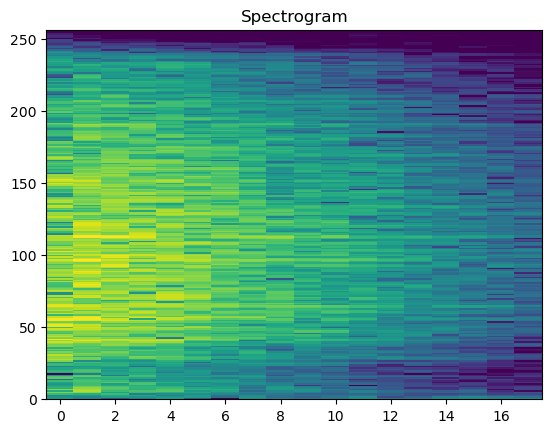

In [99]:
mfcc, label, signal, file = dataset.__getitem__(0)
mfcc = mfcc.squeeze(0)
spectrogram = T.Spectrogram(n_fft=512)
mel_spectrogram = T.MelSpectrogram(n_fft=512, n_mels=512)

spec = spectrogram(signal[0])
mel_spec = mel_spectrogram(signal[0])

print(file)
print(plot_spectrograms(spec, title='Spectrogram'))


None


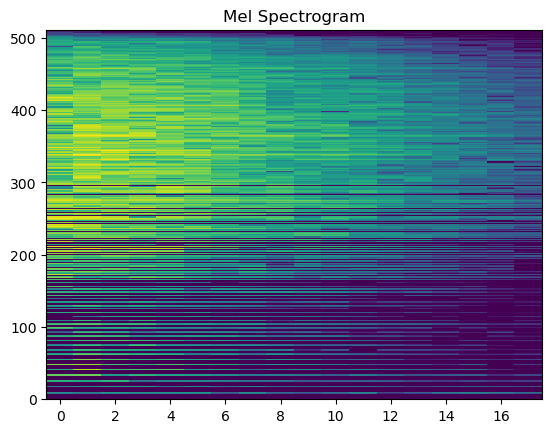

In [100]:
print(plot_spectrograms(mel_spec, title='Mel Spectrogram'))

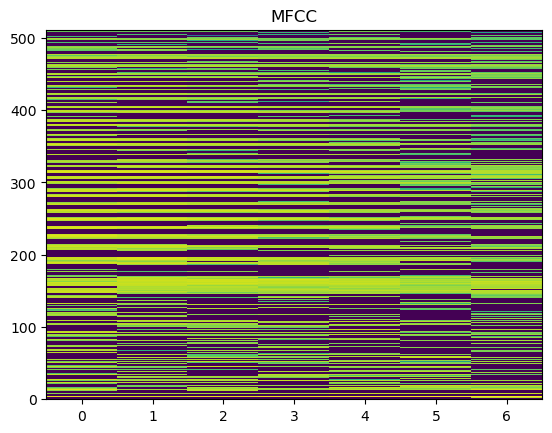

In [101]:
plot_spectrograms(mfcc, title='MFCC')

In [102]:
mfcc.shape

torch.Size([512, 7])